## R code to test for phylogenetic and temporal clustering

- The first function below calculates the correlation coefficient for the dates and the number of nodes separating a pair of tips. The dates in the phylogenetic tree should be at the end of the taxon names, after an underscore (_). Note that the branch lengths are not used, only the number nodes between pairs of tips.

- The second function randomises the dates in the tree, using the same format.

In [56]:
phylo_temporal_clustering <- function(tr){
    require(NELSI)
    dates <- sapply(tr$tip.label, function(x) as.numeric(gsub('.+_', '', x)), USE.NAMES = F)
    tips <- 1:length(tr$tip.label)
    nodes_matrix <- matrix(NA, length(tr$tip.label), length(tr$tip.label))
    dates_matrix <- matrix(NA, length(tr$tip.label), length(tr$tip.label))
    for(i in 1:(length(tips)-1)){
        for(j in (i+1):(length(tips))){
            nodes_matrix[i, j] <- length(nodepath(tr, from = i, to = j)) - 2
            dates_matrix[i, j] <- abs(dates[i]- dates[j])
        }
    }
    node_dates <- cbind(dates_matrix[upper.tri(dates_matrix)], nodes_matrix[upper.tri(nodes_matrix)])
    cor_true <- cor(node_dates[, 1], node_dates[, 2])
    return(cor_true)
}

make_randomised_tree <- function(tr){
    tr_random <- tr
    split_names <- t(as.data.frame(strsplit(tr_random$tip.label, '_')))
    split_names <- cbind(split_names[, 1], split_names[sample(1:nrow(split_names)), 2])
    new_names <- sapply(1:nrow(split_names), function(x) paste(split_names[x, ], collapse = '_'))
    tr_random$tip.label <- new_names
    return(tr_random)
}

- Load a phylogenetic tree with phylogenetic and temporal clustering. For comparisson, we randomise the dates and plot them side by side. The dates are the numbers after the space in each taxon name.

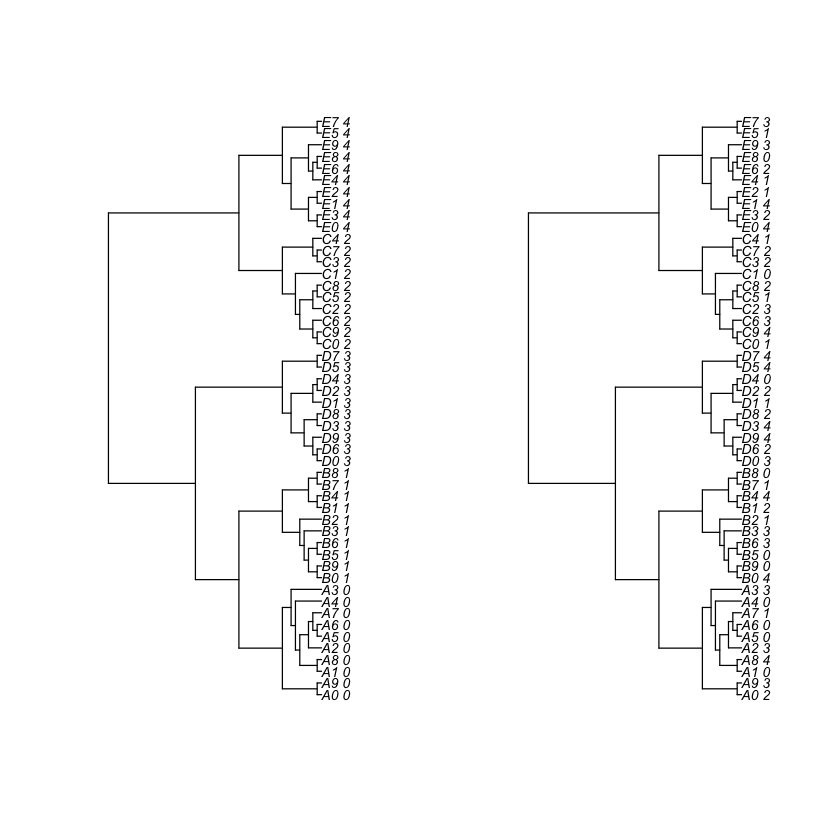

In [57]:
tr_clustered <- read.nexus('Analysis/geo_structure.trees')[[200]]
tr_clustered$edge.length <- NULL

tr_random <- make_randomised_tree(tr_clustered)
par(mfrow = c(1, 2))
plot(tr_clustered, cex = 0.7)
plot(tr_random, cex = 0.7)

- To determine whether the data have signifficant phylogenetic and temporal clustering, we compute the correlation coefficient for the original tree (with phylogenetic and temporal clustering). We also generate a null distribution by computing the correlation coefficient for 1000 trees with randomised dates. Importantly, the trees with randomised dates have the same topology as the original tree.

In [58]:
true_test_statistic <- phylo_temporal_clustering(tr_clustered)
random_test_statistic <- phylo_temporal_clustering(tr_random)
null_distro <- sapply(1:1000, function(x) phylo_temporal_clustering(make_randomised_tree(tr_clustered)))

- The P value is the number of times that the true test statistic is higher or lower than those from the null distribution. Note that I treat it here as a two tailed test.

In [59]:
0.5 - abs(0.5 - sum(true_test_statistic > null_distro) / length(null_distro))
0.5 - abs(0.5 - sum(random_test_statistic > null_distro) / length(null_distro)) 

[1] 0

[1] 0.277

- Finally, a histogram of the null distribution can be plotted. The location of the P value of the tree with phylogenetic and temporal clustering is shown in red, while that from a tree with randomly distributed dates is shown in blue (which in most cases will fall around the mode of the null distribution).

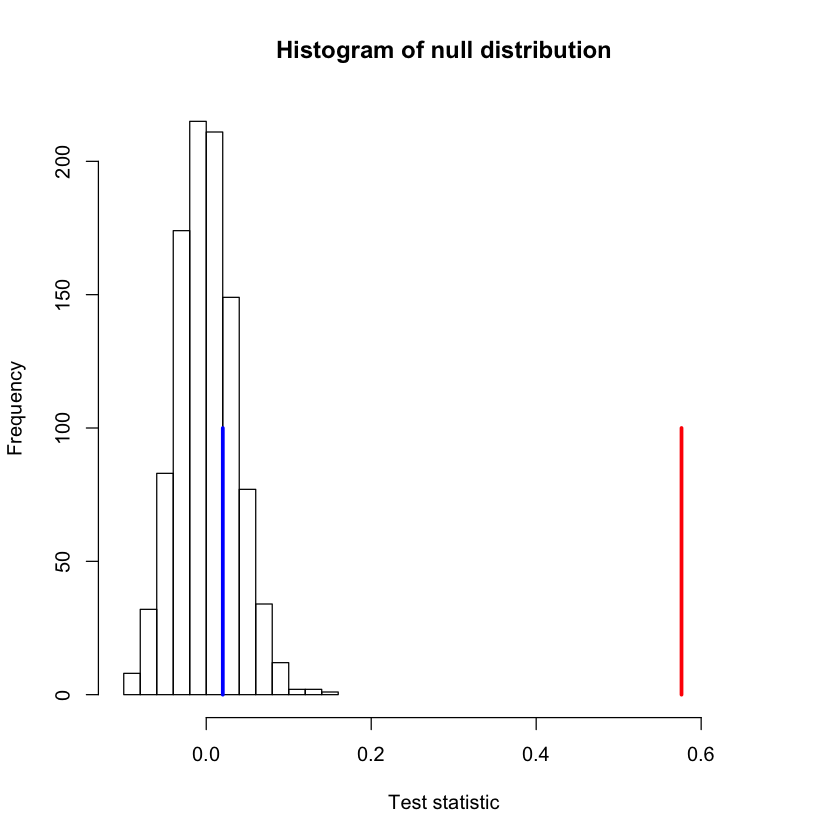

In [62]:
hist(null_distro, xlim = c(min(null_distro), true_test_statistic+0.1), main = 'Histogram of null distribution',
    xlab = 'Test statistic')
lines(x = c(true_test_statistic, true_test_statistic), y = c(0, 100), col = 'red', lwd = 3)
lines(x = c(random_test_statistic, random_test_statistic), y = c(0, 100), col = 'blue', lwd = 3)